In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [82]:
DATA_FOLDER = 'dataset'
COMPLETE_DATA = os.path.join(DATA_FOLDER, 'complete_dataset.csv')
INTERMEDIATE_DATA = os.path.join(DATA_FOLDER, 'intermediate_dataset.csv')
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')

In [83]:
df = pd.read_csv(COMPLETE_DATA)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [84]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 10
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode="distance", p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [85]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"]/n_neighbors
    score[element] = mean_dist

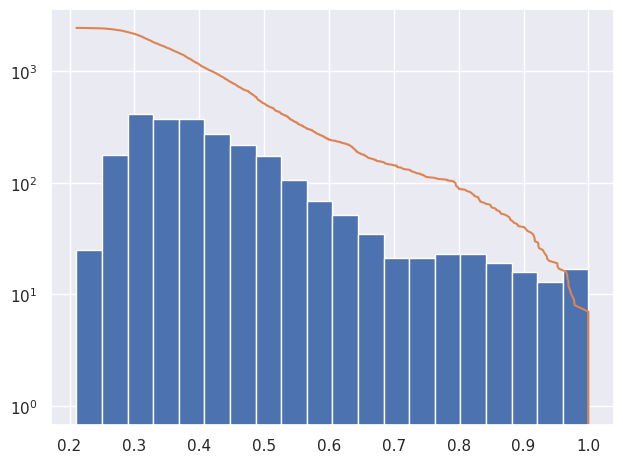

In [86]:
plt.hist(score, bins=20)
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)))
plt.yscale("log")

In [87]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(2452, 2)


348


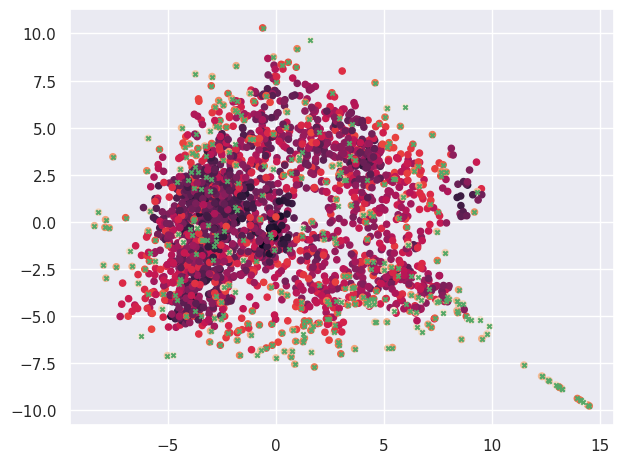

In [88]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)

<Axes: >

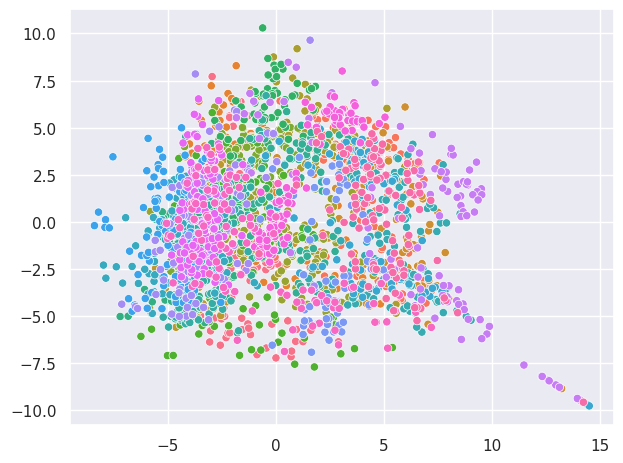

In [89]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["actor"], legend=False)

<Axes: >

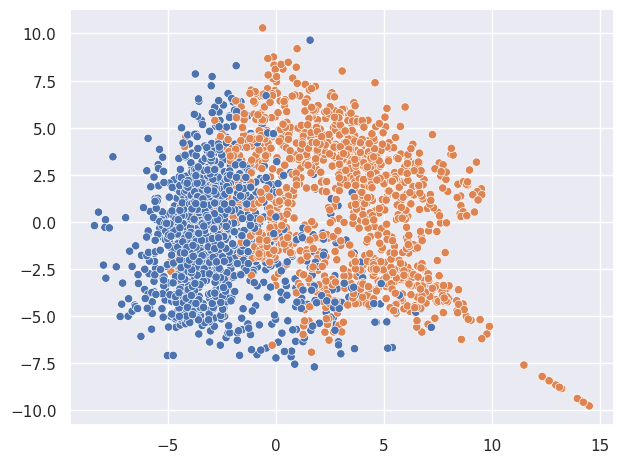

In [90]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["sex"], legend=False)

<Axes: >

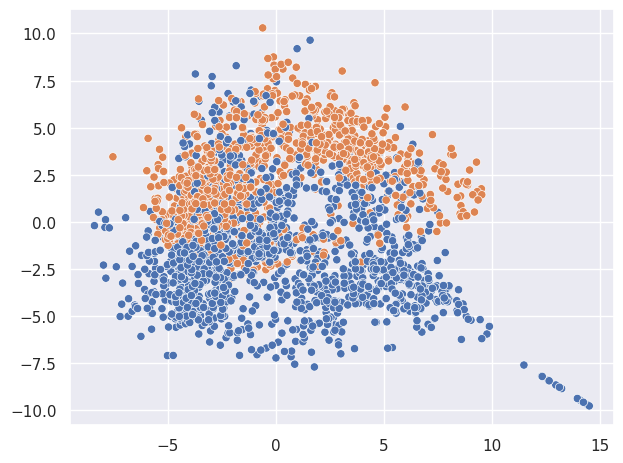

In [91]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)

<Axes: >

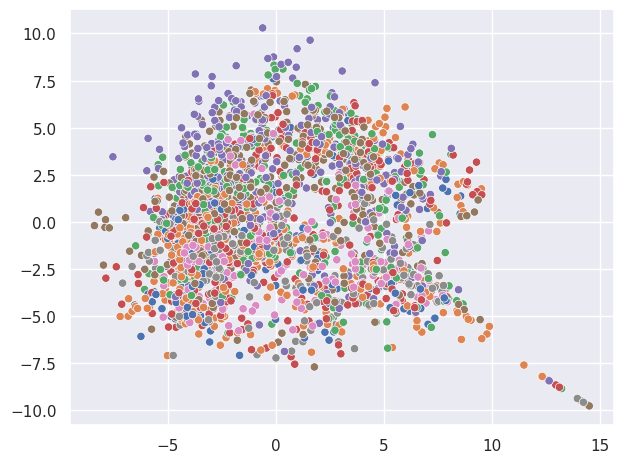

In [92]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)

In [93]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import cohen_kappa_score

test_train = 0.1
train_labels = df.emotion.values[:int(len(df)*(1-test_train))]
test_labels = df.emotion.values[int(len(df)*(1-test_train)):]
train_data = df[numerical_attr_list].values[:int(len(df)*(1-test_train)),:]
test_data = df[numerical_attr_list].values[int(len(df)*(1-test_train)):, :]

knn = KNeighborsClassifier(n_neighbors=10)

u = knn.fit(train_data, train_labels)
cohen_kappa_score( test_labels, u.predict(test_data) )



0.13620929155733918

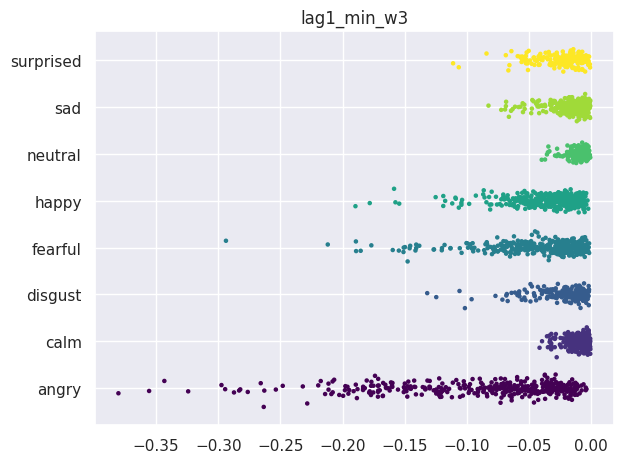

In [147]:
df_ami = pd.read_csv(os.path.join(DATA_FOLDER, "df_ami.csv"))
enc = OneHotEncoder()
labels_dict = {emo:val for val, emo in enumerate(np.unique(df.emotion.values))}
labels = list(map(labels_dict.get, df.emotion.values))
best_emo_predictors = df_ami[df_ami.cat == "emotion"].sort_values("ami", ascending=False).reset_index().loc[:5, "num"]

num = best_emo_predictors[0]
plt.scatter(df[num], labels + np.random.normal(0,0.1,size=len(df)), label=best_emo_predictors, c=labels, s= 5, cmap="viridis")
plt.yticks(range(len(labels_dict)), labels=labels_dict.keys());
plt.title(num);